# Adam Cabral
## CSC 310 Final Project Proposal

### Individual App Project: Automated Car Appraiser


My app I have made is a Car Appraiser. It is a basic GUI based app using Tkinter that has multiple fields for the user to fill in regarding their cars information. The information given is then fed through the KNN Model that is trained here in this Jupyter Notebook.

<img src="Images/roxanne-prediction.jpg" width=500>

<img src="Images/roxanne-pic.jpg" width = 400>


# Milestones
1. Clean up the dataset to conform to American unit standards.
2. Find which model gives the best accuracy for appraising cars (Linear Regression, MLP, KNN)
3. Find a way to save the best model so it does not have to train everytime the app launches.
    - I used Pickle to save the data structures and model
4. Build the app gui using Tkinter for user input.
5. Hook up the GUI to the python model for appraisal to give a price to the user.



# The Dataset: Autos.csv

##### I downloaded this dataset from: 

https://www.kaggle.com/orgesleka/used-cars-database


In [1]:
import pandas as pd
data_df = pd.read_csv("Data/autos.csv")

data_df.describe()


,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
count,3.715280e+05,371528.000000,371528.000000,371528.000000,371528.000000,371528.0,371528.00000
mean,1.729514e+04,2004.577997,115.549477,125618.688228,5.734445,0.0,50820.66764
std,3.587954e+06,92.866598,192.139578,40112.337051,3.712412,0.0,25799.08247
min,0.000000e+00,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.00000
25%,1.150000e+03,1999.000000,70.000000,125000.000000,3.000000,0.0,30459.00000
50%,2.950000e+03,2003.000000,105.000000,150000.000000,6.000000,0.0,49610.00000
75%,7.200000e+03,2008.000000,150.000000,150000.000000,9.000000,0.0,71546.00000
max,2.147484e+09,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.00000


In [392]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics

In [407]:
df = pd.read_csv("autos.csv")

## Clean up data

1. Drop useless columns
2. Convert German words/units to English/Imperial units
3. Deal with NaN's

In [408]:
# Drop useless columns 
df.drop(["name","monthOfRegistration", "abtest", "seller", "dateCrawled", "offerType", "dateCreated", "nrOfPictures", "postalCode", "lastSeen"], axis=1, inplace=True)

#### Fill NaN's with data and remove Outliers

In [411]:
df.rename(columns={"kilometer":"miles", "powerPS":"HPower"}, inplace=True)

# Remove outliers
df = df[(df.price <= 100000) & (df.price >= 300) & (df.yearOfRegistration <= 2020) & (df.yearOfRegistration >= 1769) & (df.HPower <= 2000) ]

# Fill NaN's
df.vehicleType.fillna("Other", inplace=True)
df.gearbox.fillna("manual", inplace=True)
df.model.fillna("Other", inplace=True)
df.notRepairedDamage.fillna("no", inplace=True)
df.fuelType.fillna("Gasoline", inplace=True)
df.price.fillna(df.price.mean(), inplace=True)
df.miles.fillna(df.miles.mean(), inplace=True)

In [412]:
df.describe()

,price,yearOfRegistration,HPower,miles
count,345428.000000,345428.000000,345428.000000,345428.000000
mean,5641.526993,2003.587856,114.626067,126159.271976
std,6334.698596,7.470779,73.943608,39026.937403
min,300.000000,1800.000000,0.000000,5000.000000
25%,1399.000000,1999.000000,75.000000,125000.000000
50%,3249.000000,2004.000000,109.000000,150000.000000
75%,7500.000000,2008.000000,150.000000,150000.000000
max,40000.000000,2019.000000,2000.000000,150000.000000


After removing outliers and filling NaN's the description of the dataset looks much cleaner. However, we lost 26,100 rows due to it. This isnt too bad given the size of the dataset.

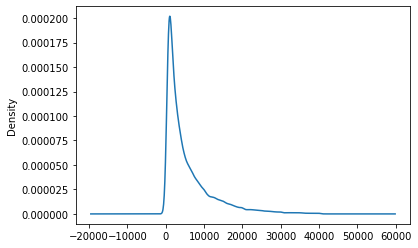

In [414]:
df["price"].plot.kde()

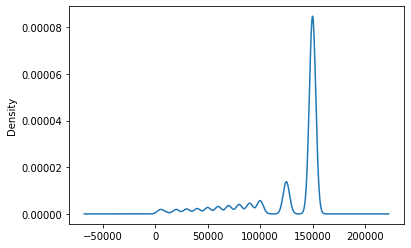

In [415]:
df["miles"].plot.kde()

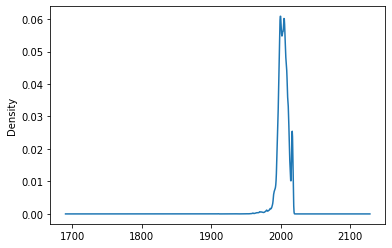

In [416]:
df["yearOfRegistration"].plot.kde()

From these density plots we can see that the data is largely centered around cars within the 0-10000 dollar price range. Also those cars all share a common mileage of around 150000 miles. This is typical for a care in that price range!

#### Translate German words to English

In [419]:
#Map German words to english
df['gearbox'] = df['gearbox'].map({'manuell':'manual', 'automatik':'automatic', 'manuel':'manuel'}).astype(str)
df['miles'] = df['miles'].map(lambda x: int(x*0.62137))


# lpg: Liquefied petroleum gas
# benzin: Regular Gasoline
# cng: Compressed Natural Gas
# andere: Other
# elektro: Electric
df['fuelType'] = df['fuelType'].map({"benzin":"Gasoline", "andere":"other", "elektro":"electric", "lpg":"lpg", "cng":"cng", "diesel":"diesel", "hybrid":"hybrid", "Other":"Other", "Gasoline":"Gasoline"})

df['notRepairedDamage'] = df['notRepairedDamage'].map({"nein":"no", "ja":"yes"})
df['vehicleType'] = df['vehicleType'].map({'limousine': 'sedan', 'kleinwagen':'mini','kombi':'combination', "bus":"bus",'cabrio':'convertable',"coupe":"coupe", "suv":"suv", 'andere': 'Other', 'Other':"Other"})


#### Enumerate Values for Regression

In [420]:
# Vehicle Type Enumeration
vehicleTypes = {}
count = 0
for entry in df['vehicleType']:
    if entry not in vehicleTypes:
        vehicleTypes[entry] = count
        count+=1
# df["vehicleType"] = df['vehicleType'].map(vehicleTypes)

# Gearbox Enumeration
count = 0
gearBoxes = {}
for entry in df['gearbox']:
    if entry not in gearBoxes:
        gearBoxes[entry] = count
        count+=1
# df["gearbox"] = df['gearbox'].map(gearBoxes)

# Model Enumeration
count = 0
models = {}
for entry in df['model']:
    if entry not in models:
        models[entry] = count
        count+=1
# df["model"] = df["model"].map(models)

# Fuel type Enumeration
count = 0
fuelTypes = {}
for entry in df['fuelType']:
    if entry not in fuelTypes:
        fuelTypes[entry] = count
        count+=1
# df["fuelType"] = df["fuelType"].map(fuelTypes)

# Brand Enumeration
count = 0
brands = {}

for entry in df['brand']:
    if entry not in brands:
        brands[entry] = count
        count+=1

# df['brand'] = df['brand'].map(brands)

count = 0
damages = {}
for entry in df["notRepairedDamage"]:
    if entry not in damages:
        damages[entry] = count
        count+=1
del damages[np.nan]
# df["notRepairedDamage"] = df["notRepairedDamage"].map(damages)



# Make Dummy Variables for Classification Columns
cols = ['vehicleType','gearbox','model','fuelType','brand', "notRepairedDamage"]

df = pd.get_dummies(df, columns=cols)



In [421]:
print(df.shape)
df.head()

(345428, 315)


,price,yearOfRegistration,HPower,miles,vehicleType_Other,vehicleType_bus,vehicleType_combination,vehicleType_convertable,vehicleType_coupe,vehicleType_mini,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,notRepairedDamage_no,notRepairedDamage_yes
0,480,1993,0,93205,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,18300,2011,190,77671,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,77671,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1500,2001,75,93205,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
4,3600,2008,69,55923,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


### Setup Training and Testing Sets

In [373]:
target_df = df["price"]
feat_df = df.drop(["price"], axis=1)

In [374]:

train_feat, test_feat, train_targ, test_targ = train_test_split(feat_df, target_df, train_size=0.7, test_size=0.3)


# Linear Regression Model

In [375]:
pipeline = make_pipeline(LinearRegression())

linear_model = pipeline.fit(train_feat, train_targ)
# linear_model = LinearRegression(fit_intercept=True)
# linear_model.fit(train_feat, train_targ)

In [376]:
linear_scores = cross_val_score(linear_model, test_feat, test_targ, cv=3)
print("Fold Accuracies: {}".format(linear_scores))
print("Mean Linear Regression Accuracy: {}".format(linear_scores.mean()))

Fold Accuracies: [ 0.59295615  0.58642773 -0.88233994]
Mean Linear Regression Accuracy: 0.09901464678762169


# MLP Model

In [380]:
# seed = np.random.seed()


pipeline = make_pipeline(MLPRegressor())
# mlp_model = MLPRegressor(activation="logistic", hidden_layer_sizes=(25,50,100), max_iter=100, verbose=True, learning_rate = 'adaptive', learning_rate_init = 100)
mlp_model = pipeline.fit(train_feat, train_targ)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [381]:
print("MLP R^2 score: {}".format(mlp_model.score(test_feat, test_targ)))

MLP R^2 score: 0.6938620813062452


## KNN Regression

In [377]:
knn_model = KNeighborsRegressor(n_neighbors=5, weights="distance")

In [378]:
knn_model.fit(train_feat, train_targ)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='distance')

In [379]:
print("KNN R^2 score : {}".format(knn_model.score(test_feat,test_targ)))

KNN R^2 score : 0.8331420891339929


# Export model and dictionaries using pickle

In [337]:
# Make a default test row
test_df = feat_df.iloc[2,:].copy()

for i in range(len(test_df)):
    test_df[i] = 0

test_df

yearOfRegistration       0
HPower                   0
miles                    0
monthOfRegistration      0
vehicleType_Other        0
                        ..
brand_trabant            0
brand_volkswagen         0
brand_volvo              0
notRepairedDamage_no     0
notRepairedDamage_yes    0
Name: 2, Length: 316, dtype: int64

In [338]:
# index 0 = MLP Model 
# index 1 = Vehicle Types
# index 2 = Gearbox Types
# index 3 = Model Types
# index 4 = Fuel Types
# index 5 = Make Types
# index 6 = Damage Types
structures = [knn_model, vehicleTypes, gearBoxes, models, fuelTypes, brands, damages]

In [341]:
output_filename = 'Data/data_structures-knn3.sav'
output_filename

'data_structures-knn3.sav'

In [342]:
pickle.dump(structures, open(output_filename, 'wb'))
pickle.dump(test_df, open("Data/default_df.sav", 'wb'))

### Test that the pickle export worked

In [334]:

test = pickle.load(open(output_filename, 'rb'))
aaa = pickle.load(open("Data/default_df.sav", 'rb'))

In [335]:

test[0].predict([aaa])

array([4630.])


0.8331420891339929

0.24584327532246297


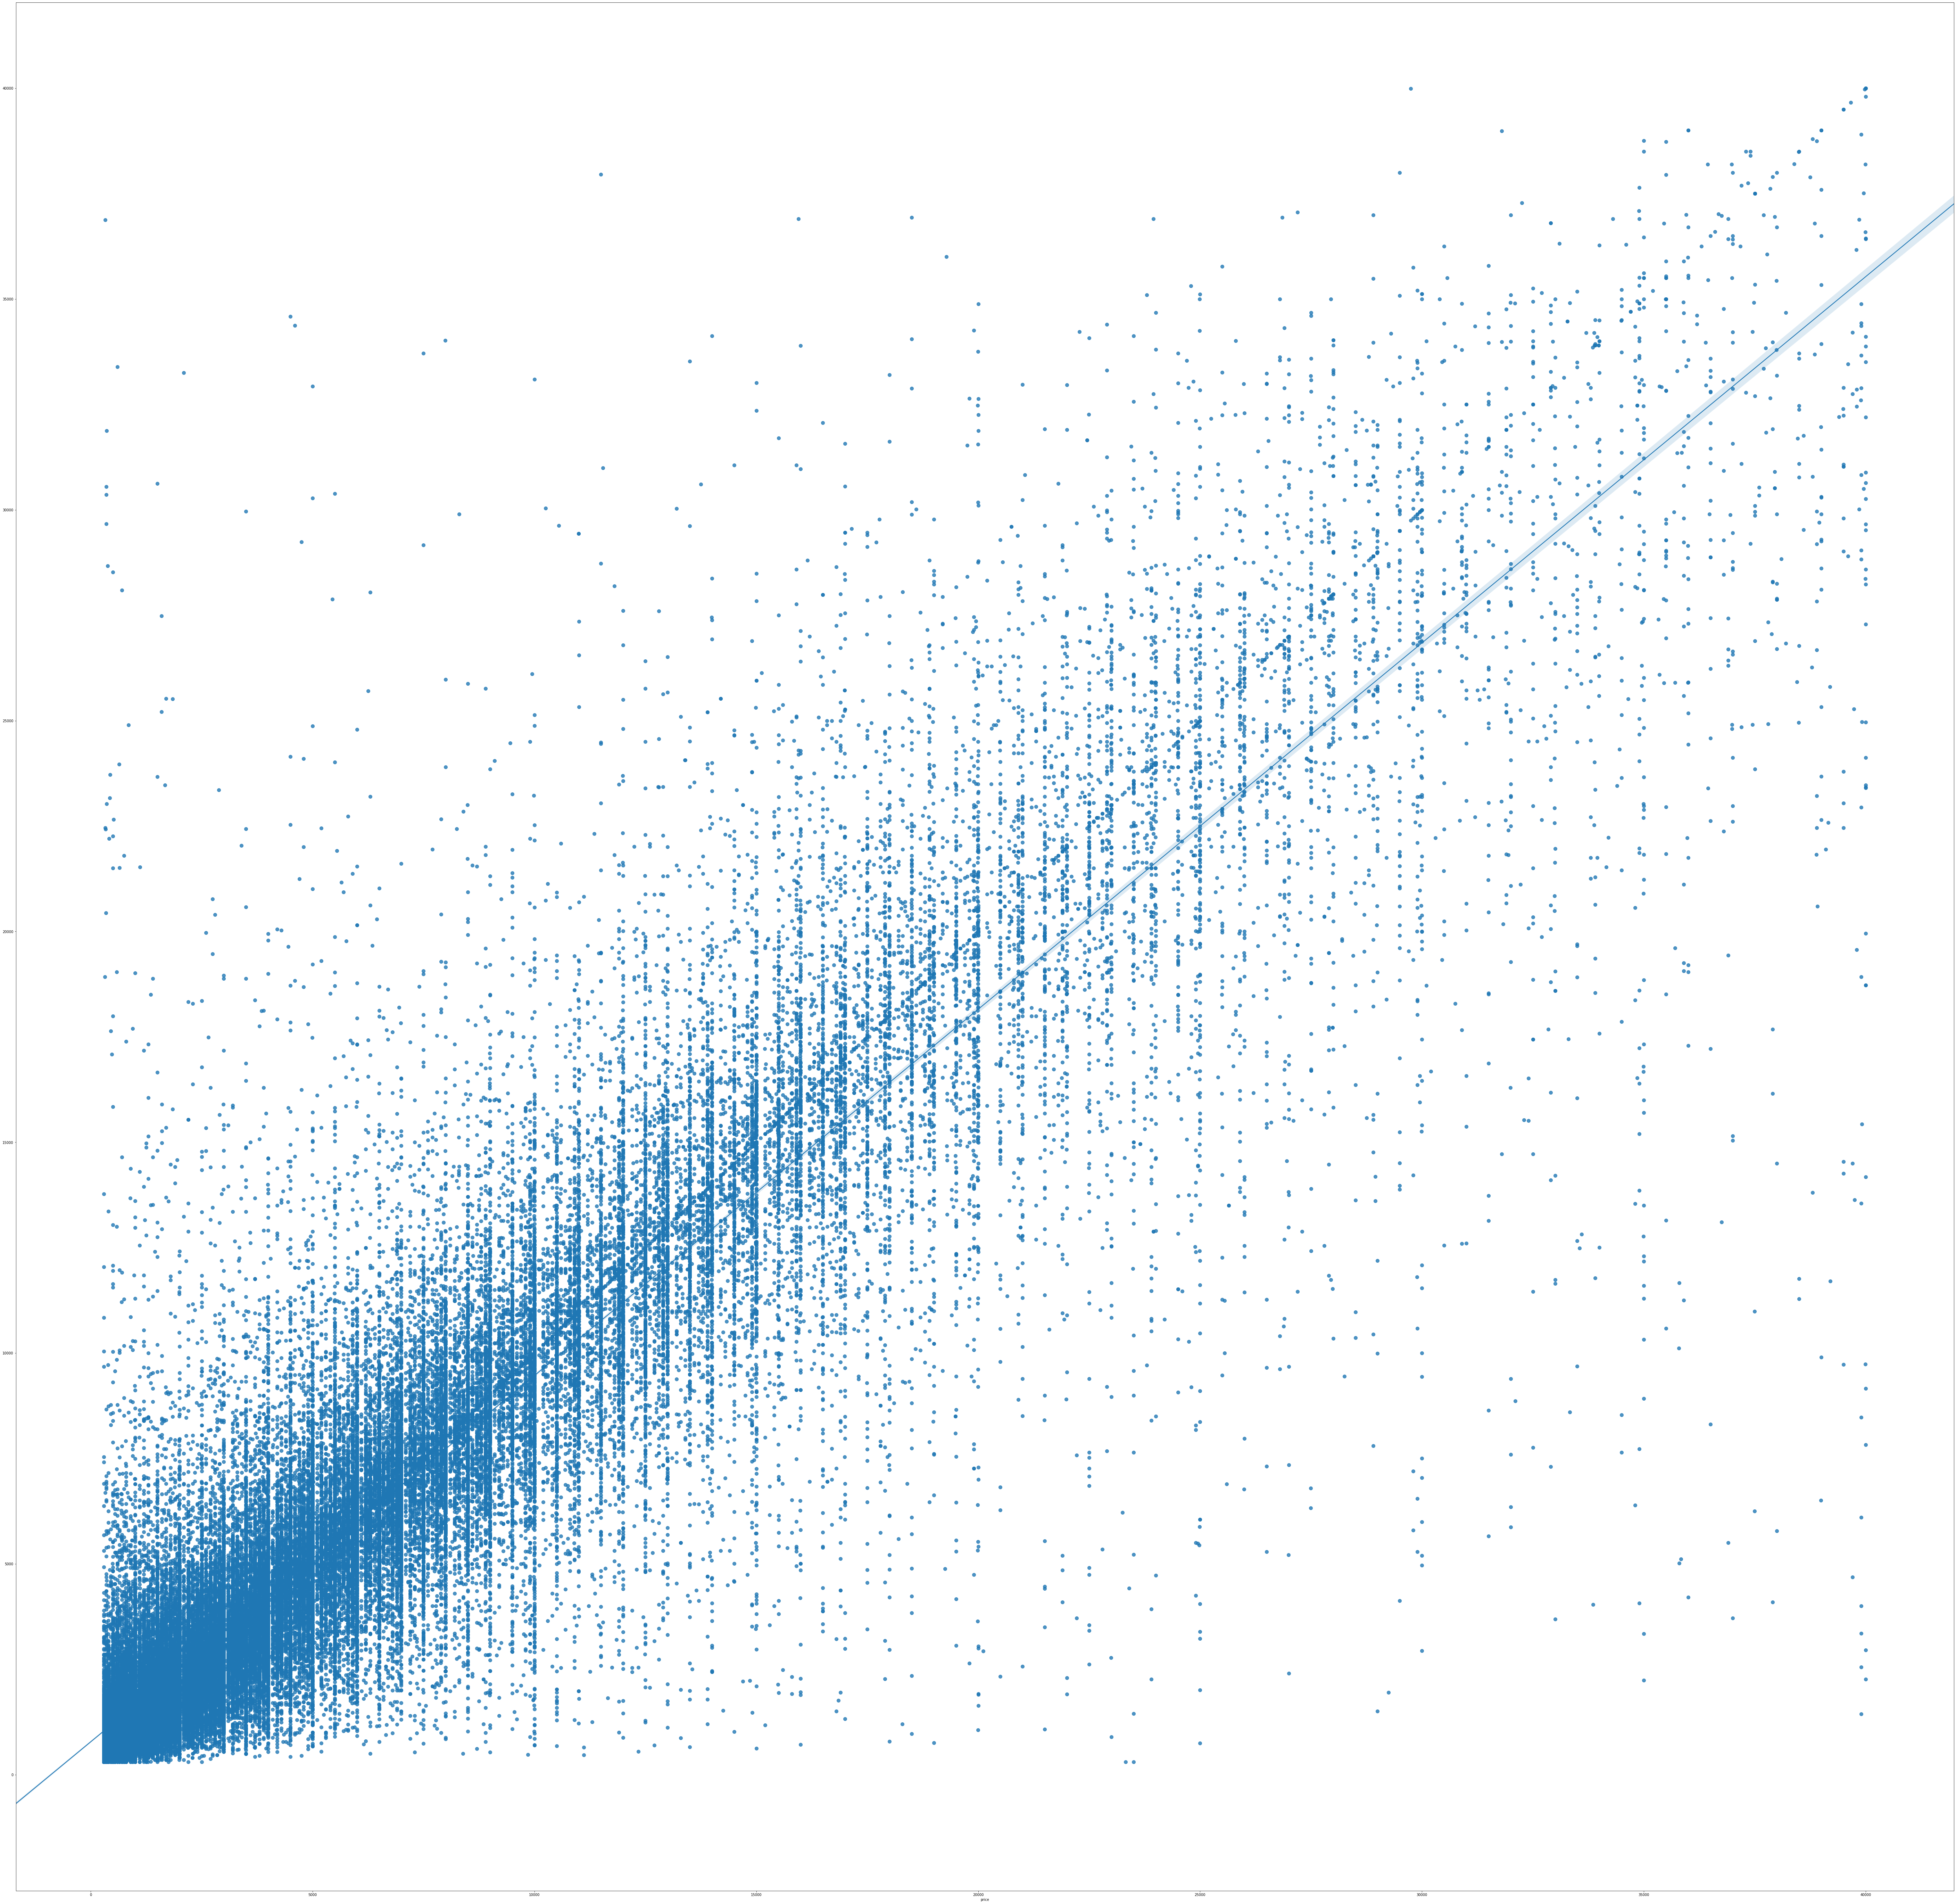

In [417]:
expected_y  = test_targ
predicted_y = knn_model.predict(test_feat)

print(); print(metrics.r2_score(expected_y, predicted_y))
print(); print(metrics.mean_squared_log_error(expected_y, predicted_y))
plt.figure(figsize=(100,100))
sns.regplot(expected_y, predicted_y, fit_reg=True, scatter_kws={"s": 100})


In [97]:
df.head(1000)

,price,vehicleType,yearOfRegistration,gearbox,HPower,model,miles,monthOfRegistration,fuelType,brand,notRepairedDamage
0,480,0,1993,0,0,0,93205,0,0,0,0
1,18300,1,2011,0,190,1,77671,5,1,1,1
2,9800,2,2004,1,163,2,77671,8,1,2,0
3,1500,3,2001,0,75,0,93205,6,0,0,0
4,3600,3,2008,0,69,3,55923,7,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...
995,1999,5,1996,0,131,6,77671,4,0,15,0
996,139997,1,2010,0,435,152,12427,3,0,27,0
997,3999,5,2007,1,84,29,93205,9,0,17,0
998,2600,0,2017,1,101,9,93205,4,1,0,0
